# Simulations 

> Comparison of operation modes on the local network

In [2]:
#| default_exp use

In [3]:
#| export
from fastcore.utils import *

import pandas as pd
from cylinder.hwc_2node import HWC
from cylinder.demand import *
from cylinder.power import *
from cylinder.utils import *
import pandas as pd	
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
from collections import defaultdict
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D



In [4]:
#| export
#| hide
@patch
def _thermostat(self:HWC):
    "Thermostat state change"
    # Nodal cylinder thermostat
    self.thermostat[0] = 0 if self.temperatures[1] > self.T_set else self.thermostat[0] # Turn off if T > T_set
    self.thermostat[0] = 1 if self.temperatures[1] < self.T_set- self.T_deadband else self.thermostat[0] # Turn on the element
    # Nodal cylinder thermostat
    self.thermostat[1] = 0 if self.temperatures[1] > self.T_set_bu else self.thermostat[1] # Turn off if T > T_set
    self.thermostat[1] = 1 if self.temperatures[1] < self.T_set_bu- self.T_deadband else self.thermostat[1] # Turn on the element
    return self.thermostat

Want to look at some parameters around the cylinder profile and control philosophy to see the impact of these on three aspects:

* The local network lines demand - particularly at peak times where the lines face constraints
* The cost of power to service the demand

## Assumptions

In order to have reasonable comparisons over different operating scenarios we will use the draw profile of a specific 4 bedroom unit from a historical hot water usage dataset.

In [5]:
# | hide
power = load_power(path = Path('../data/'), ripple_control=True)#/home/cjp/cylinder/data/powerprices.csv
strategies = {}
df = {} 

## Base Case

The base installation is a typical 180L hot water cylinder in a 4 bedroom houshold

In [6]:
strategies[0] = {'name': 'Baseline: ~180L 3kW cylinder operating at 60 degrees C under thermotstat control with ripple control power supply',
                'operation': 'continuous',
                'bedrooms': 4,
                'element' :3,
                'Tset_H' : 60,
                'Tset_L' : 60,
                'radius' : 0.22,
                'height' : 1.1,
                'ripple' : True}

In [7]:
#| hide
strategy = 0
time_period = '2020-06'
env = HWC(T_set=strategies[strategy]['Tset_H'], 
            radius=strategies[strategy]['radius'],
            height=strategies[strategy]['height'],
            element=strategies[strategy]['bedrooms'],
            U=.8)
temp = []
flow = load_demand(path = Path('../data/drawprofiles'),
                    bed=strategies[strategy]['bedrooms'],
                    unit=3).loc[:,'flow']
for row in power.loc[time_period].itertuples(): # go through a set time period
    action = 0
    pwr = [1,1]
    
    # adjust for temperature
    env._thermostat()
    # establish if there is power going to the element based on the thermostat state and the strategy in relation to ripple control
    if env.thermostat[0] == 1: # if the thermostat high temperature sensor is on then need to look to the control strategy
        if strategies[strategy]['operation'] == 'off_peak': # if the strategy is to use the thermostat high temperature sensor then the element is on
            action = ~row.peak
        elif strategies[strategy]['operation'] == 'continuous': # if the strategy is to use the thermostat high temperature sensor then the element is on
            action = 1
        elif strategies[strategy]['operation'] == 'price': # if the strategy is to use the thermostat high temperature sensor then the element is on
            # action = 1 if row.cost < 0.1 else 0
            action = 1 if row.costrank_8h < 0.2 else 0

            pwr = [0,1]


    if env.thermostat[1] == 1: # if the thermostat base temperature sensor is on then the element is on
        action = 1
    

    if (strategies[strategy]['ripple']) & (row.ripple_control): # if ripple control is on then override the thermostat state
        action = 0
        pwr[1] = 0 # no power to the element

    env._update_model(action = action , flow = 2* flow.loc[row.Index]*60)
    temp.append([strategy,
                action,
                row.ripple_control * strategies[strategy]['ripple'] ,
                *env.thermostat.copy(),
                *env.temperatures.copy(),
                env.z,
                env.volume])
tmp = pd.DataFrame(temp, 
                        columns=['strategy',
                                    'action',
                                    'ripple_control_demand',
                                    'thermostat_high',
                                    'thermostat_base',
                                    'T0',
                                    'T1',
                                    'z',
                                    'volume'])
df[strategy] = pd.concat([power.loc[time_period].reset_index(),
            flow.loc[time_period].reset_index(drop=True),
            tmp.assign(energy = lambda df: df.volume.mean()*4.2*((df.T0*df.z + df.T1*(1-df.z))-55))],axis=1).set_index('timestamp')

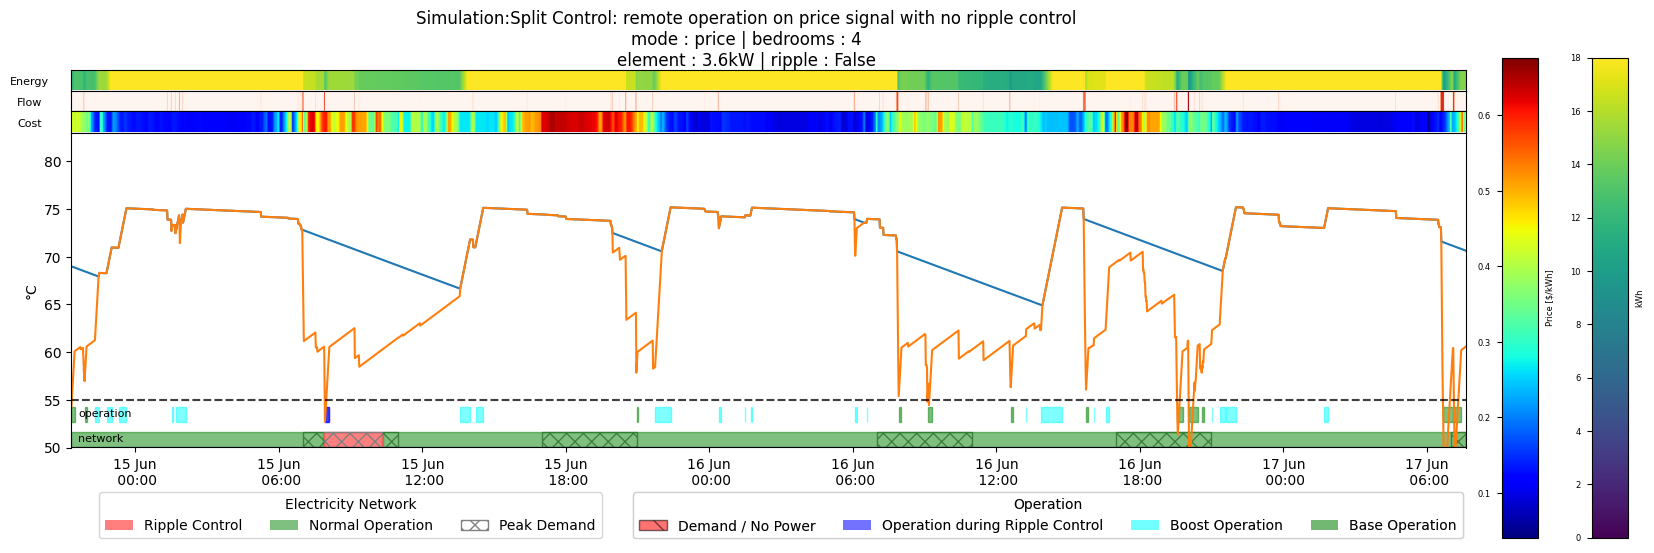

In [23]:
# |filter_stream FutureWarning
plot_sim(strategies[strategy], df[strategy].iloc[20000:23500])

## Base Case without Ripple Control

The base installation is a typical 180L hot water cylinder in a 4 bedroom houshold however the cylinder is not interupted by ripple control


In [24]:
strategies[1] = {'name':'Baseline case: current operation with no ripple control',
            'operation': 'off_peak',
            'bedrooms': 4,
            'element' :3,
            'Tset_H' : 60,
            'Tset_L' : 60,
            'radius' : 0.22,
            'height' : 1.1,
            'ripple' : False}

In [25]:
#| hide
time_period = '2020-06'
strategy = 1
env = HWC(T_set=strategies[strategy]['Tset_H'], 
            radius=strategies[strategy]['radius'],
            height=strategies[strategy]['height'],
            element=strategies[strategy]['bedrooms'],
            U=.8)
temp = []
flow = load_demand(path = Path('../data/drawprofiles'),
                    bed=strategies[strategy]['bedrooms'],
                    unit=3).loc[:,'flow']
for row in power.loc[time_period].itertuples(): # go through a set time period
    action = 0
    pwr = [1,1]
    
    # adjust for temperature
    env._thermostat()
    # establish if there is power going to the element based on the thermostat state and the strategy in relation to ripple control
    if env.thermostat[0] == 1: # if the thermostat high temperature sensor is on then need to look to the control strategy
        if strategies[strategy]['operation'] == 'off_peak': # if the strategy is to use the thermostat high temperature sensor then the element is on
            action = ~row.peak
        elif strategies[strategy]['operation'] == 'continuous': # if the strategy is to use the thermostat high temperature sensor then the element is on
            action = 1
        elif strategies[strategy]['operation'] == 'price': # if the strategy is to use the thermostat high temperature sensor then the element is on
            # action = 1 if row.cost < 0.1 else 0
            action = 1 if row.costrank_8h < 0.2 else 0

            pwr = [0,1]


    if env.thermostat[1] == 1: # if the thermostat base temperature sensor is on then the element is on
        action = 1
    

    if (strategies[strategy]['ripple']) & (row.ripple_control): # if ripple control is on then override the thermostat state
        action = 0
        pwr[1] = 0 # no power to the element

    env._update_model(action = action , flow = 2* flow.loc[row.Index]*60)
    temp.append([strategy,
                action,
                row.ripple_control * strategies[strategy]['ripple'] ,
                *env.thermostat.copy(),
                *env.temperatures.copy(),
                env.z,
                env.volume])
tmp = pd.DataFrame(temp, 
                        columns=['strategy',
                                    'action',
                                    'ripple_control_demand',
                                    'thermostat_high',
                                    'thermostat_base',
                                    'T0',
                                    'T1',
                                    'z',
                                    'volume'])
df[strategy] = pd.concat([power.loc[time_period].reset_index(),
            flow.loc[time_period].reset_index(drop=True),
            tmp.assign(energy = lambda df: df.volume.mean()*4.2*((df.T0*df.z + df.T1*(1-df.z))-55))],axis=1).set_index('timestamp')


/home/cjp/cylinder/cylinder/utils.py:37: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row in ser.iteritems():


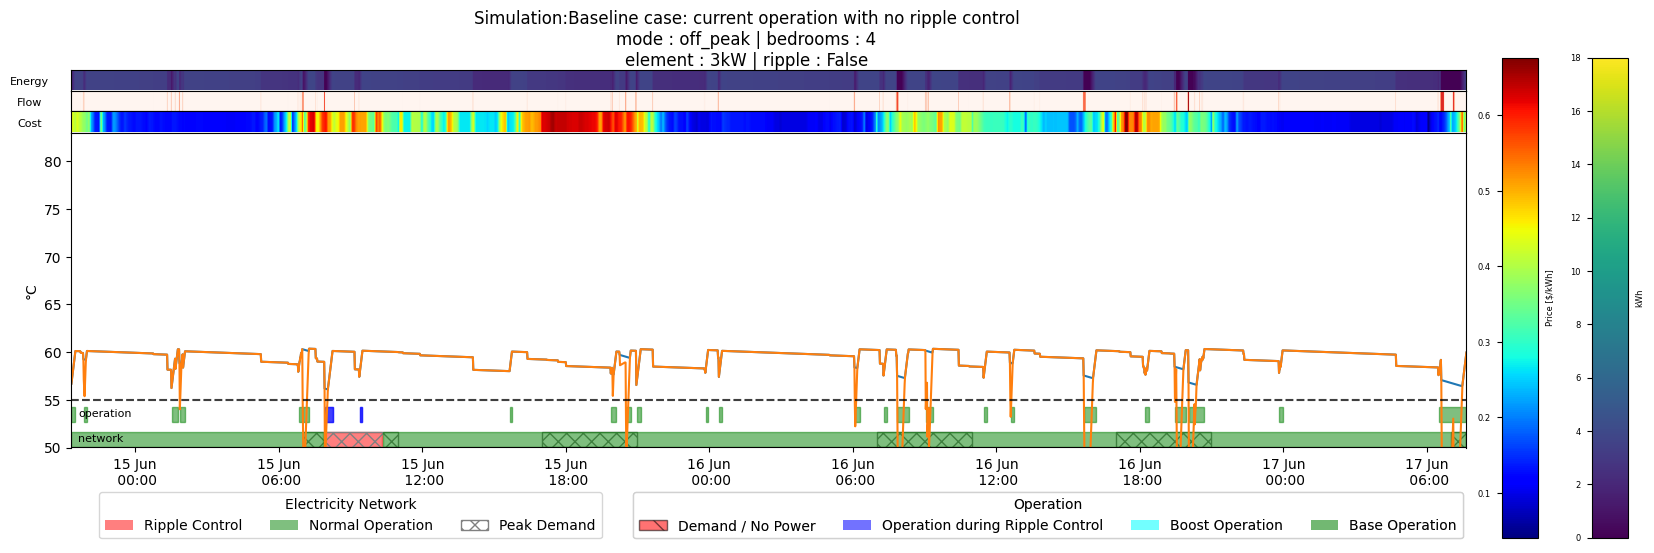

In [26]:
# |filter_stream FutureWarning
plot_sim(strategies[strategy], df[strategy].iloc[20000:23500])

## Thermal Boosting on Base Case with Ripple Control

Apply Thermal Boosting Control on the base installation with the cylinder having interupted power supply by ripple control

In [27]:
strategies[2] = {'name': 'Split Control: remote operation on price signal with ripple control',
            'operation': 'price',
            'bedrooms': 4,
            'element' :3,
            'Tset_H' : 75,
            'Tset_L' : 60,
            'radius' : 0.22,
            'height' : 1.1,
            'ripple' : True}

In [13]:
#| hide
time_period = '2020-06'
strategy = 2
env = HWC(T_set=strategies[strategy]['Tset_H'], 
            radius=strategies[strategy]['radius'],
            height=strategies[strategy]['height'],
            element=strategies[strategy]['bedrooms'],
            U=.8)
temp = []
flow = load_demand(path = Path('../data/drawprofiles'),
                    bed=strategies[strategy]['bedrooms'],
                    unit=3).loc[:,'flow']
for row in power.loc[time_period].itertuples(): # go through a set time period
    action = 0
    pwr = [1,1]
    
    # adjust for temperature
    env._thermostat()
    # establish if there is power going to the element based on the thermostat state and the strategy in relation to ripple control
    if env.thermostat[0] == 1: # if the thermostat high temperature sensor is on then need to look to the control strategy
        if strategies[strategy]['operation'] == 'off_peak': # if the strategy is to use the thermostat high temperature sensor then the element is on
            action = ~row.peak
        elif strategies[strategy]['operation'] == 'continuous': # if the strategy is to use the thermostat high temperature sensor then the element is on
            action = 1
        elif strategies[strategy]['operation'] == 'price': # if the strategy is to use the thermostat high temperature sensor then the element is on
            # action = 1 if row.cost < 0.1 else 0
            action = 1 if row.costrank_8h < 0.2 else 0

            pwr = [0,1]


    if env.thermostat[1] == 1: # if the thermostat base temperature sensor is on then the element is on
        action = 1
    

    if (strategies[strategy]['ripple']) & (row.ripple_control): # if ripple control is on then override the thermostat state
        action = 0
        pwr[1] = 0 # no power to the element

    env._update_model(action = action , flow = 2* flow.loc[row.Index]*60)
    temp.append([strategy,
                action,
                row.ripple_control * strategies[strategy]['ripple'] ,
                *env.thermostat.copy(),
                *env.temperatures.copy(),
                env.z,
                env.volume])
tmp = pd.DataFrame(temp, 
                        columns=['strategy',
                                    'action',
                                    'ripple_control_demand',
                                    'thermostat_high',
                                    'thermostat_base',
                                    'T0',
                                    'T1',
                                    'z',
                                    'volume'])
df[strategy] = pd.concat([power.loc[time_period].reset_index(),
            flow.loc[time_period].reset_index(drop=True),
            tmp.assign(energy = lambda df: df.volume.mean()*4.2*((df.T0*df.z + df.T1*(1-df.z))-55))],axis=1).set_index('timestamp')


/home/cjp/cylinder/cylinder/utils.py:37: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row in ser.iteritems():


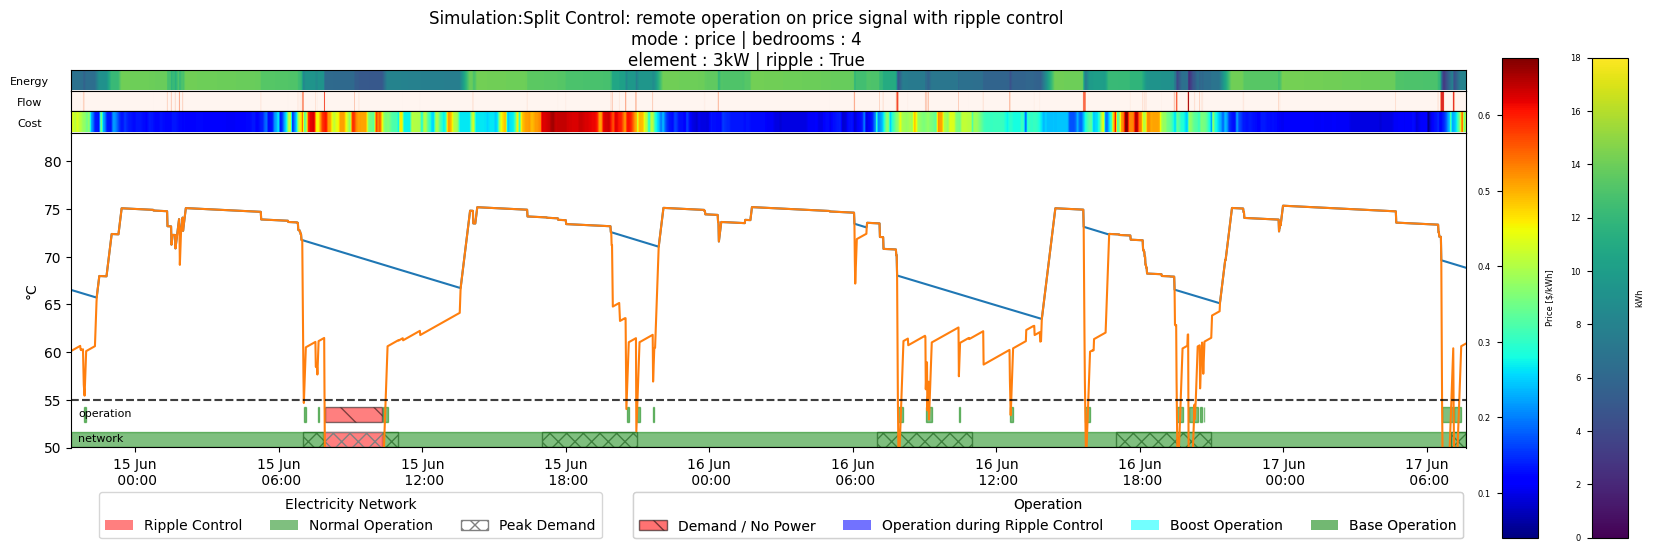

In [14]:
# |filter_stream FutureWarning
plot_sim(strategies[strategy], df[strategy].iloc[20000:23500])

## Thermal Boosting with larger cylinder and element

Apply Thermal Boosting Control on a ~280 L cylinder with a slightly larger element.

In [15]:
strategies[3] = {'name': 'Split Control: remote operation on price signal with no ripple control',
            'operation': 'price',
            'bedrooms': 4,
            'element' :3.6,
            'Tset_H' : 75,
            'Tset_L' : 60,
            'radius' : 0.25,
            'height' : 1.4,
            'ripple' : False}

In [16]:
#| hide
time_period = '2020-06'
strategy = 3
env = HWC(T_set=strategies[strategy]['Tset_H'], 
            radius=strategies[strategy]['radius'],
            height=strategies[strategy]['height'],
            element=strategies[strategy]['bedrooms'],
            U=.8)
temp = []
flow = load_demand(path = Path('../data/drawprofiles'),
                    bed=strategies[strategy]['bedrooms'],
                    unit=3).loc[:,'flow']
for row in power.loc[time_period].itertuples(): # go through a set time period
    action = 0
    pwr = [1,1]
    
    # adjust for temperature
    env._thermostat()
    # establish if there is power going to the element based on the thermostat state and the strategy in relation to ripple control
    if env.thermostat[0] == 1: # if the thermostat high temperature sensor is on then need to look to the control strategy
        if strategies[strategy]['operation'] == 'off_peak': # if the strategy is to use the thermostat high temperature sensor then the element is on
            action = ~row.peak
        elif strategies[strategy]['operation'] == 'continuous': # if the strategy is to use the thermostat high temperature sensor then the element is on
            action = 1
        elif strategies[strategy]['operation'] == 'price': # if the strategy is to use the thermostat high temperature sensor then the element is on
            # action = 1 if row.cost < 0.1 else 0
            action = 1 if row.costrank_8h < 0.2 else 0

            pwr = [0,1]


    if env.thermostat[1] == 1: # if the thermostat base temperature sensor is on then the element is on
        action = 1
    

    if (strategies[strategy]['ripple']) & (row.ripple_control): # if ripple control is on then override the thermostat state
        action = 0
        pwr[1] = 0 # no power to the element

    env._update_model(action = action , flow = 2* flow.loc[row.Index]*60)
    temp.append([strategy,
                action,
                row.ripple_control * strategies[strategy]['ripple'] ,
                *env.thermostat.copy(),
                *env.temperatures.copy(),
                env.z,
                env.volume])
tmp = pd.DataFrame(temp, 
                        columns=['strategy',
                                    'action',
                                    'ripple_control_demand',
                                    'thermostat_high',
                                    'thermostat_base',
                                    'T0',
                                    'T1',
                                    'z',
                                    'volume'])
df[strategy] = pd.concat([power.loc[time_period].reset_index(),
            flow.loc[time_period].reset_index(drop=True),
            tmp.assign(energy = lambda df: df.volume.mean()*4.2*((df.T0*df.z + df.T1*(1-df.z))-55))],axis=1).set_index('timestamp')


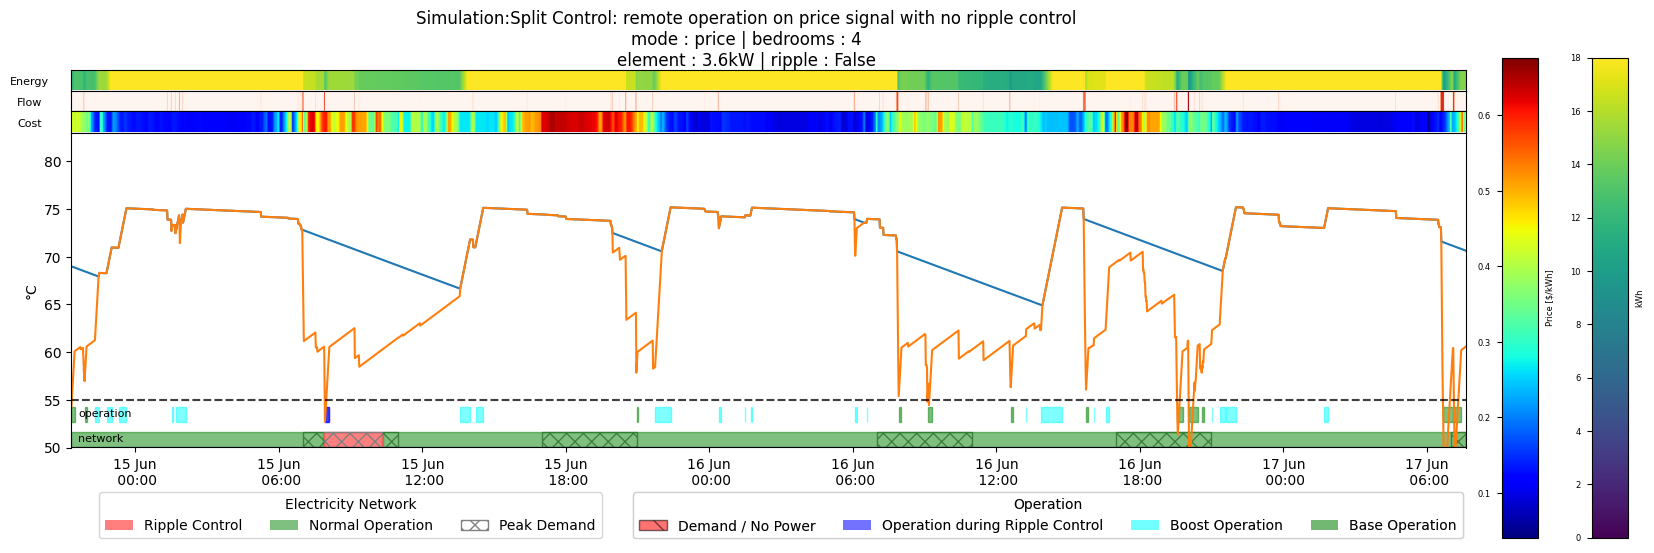

In [22]:
# |filter_stream FutureWarning
plot_sim(strategies[strategy], df[strategy].iloc[20000:23500])

# Compare Simultions 

In [18]:
#| hide
data = []
for n, sim in enumerate(df):
    t_mean = (0.7*df[n].T0.mean()+ 0.3*df[n].T1.mean())
    peak_demand = (df[n].peak*strategies[n]["element"]*df[n].action).sum()/len(df[n])
    # print(f'demand at peak : {100*peak_demand:.2f}%')
    local_kwh = (df[n].action*strategies[n]["element"]/60*df[n].thermostat_base*(df[n].ripple_control!=1)).sum()
    remote_kwh = (df[n].action*strategies[n]["element"]/60*df[n].thermostat_high*(df[n].thermostat_base!=1)).sum()
    # print(f'Local kWh : {local_kwh:.2f}',end=' ')
    # print(f'Remote kWh : {remote_kwh:.2f}')
    local_cost = (df[n].cost*strategies[n]["element"]/60*df[n].action*df[n].thermostat_base).sum()
    remote_cost = (df[n].cost*strategies[n]["element"]/60*df[n].action*df[n].thermostat_high*(df[n].thermostat_base!=1)).sum()
    # print(f'Local Cost : {local_cost/local_kwh:.2f}',end=' ')
    # print(f'Remote Cost : {remote_cost/remote_kwh:.2f}')

    loss_of_service = 100*(df[n].T0<55).sum()/len(df[n])
    days = (df[0].iloc[-1].name-df[0].iloc[0].name).days
    # print(f'Days : {days:.2f}')    
    # print(f'Loss of Service : {100*loss_of_service:.2f}%')    
    data.append([*strategies[n].values(),
                 df[n].iloc[0].name,
                 df[n].iloc[-1].name,
                 df[n].volume.mean()*1000,
                 peak_demand,
                 local_kwh,
                 remote_kwh,
                 local_kwh+remote_kwh,
                 local_cost,
                 remote_cost,
                 local_cost+remote_cost,
                 t_mean,
                 loss_of_service])
summary = pd.DataFrame(data,columns=list(strategies[0].keys())+['start_time', 'end_time', 'volume','peak_demand', 'local_kwh', 'remote_kwh', 'total_kwh', 'local_cost', 'remote_cost', 'total_cost', 't_mean', 'loss_of_service'])
summary['peak_reduction'] = 100*(summary.peak_demand-summary.loc[0,'peak_demand'])/summary.loc[0,'peak_demand']
summary['cost_reduction'] = 100*(summary.total_cost-summary.loc[0,'total_cost'])/summary.loc[0,'total_cost']


In [19]:
summary.T

,0,1,2,3
name,Baseline: ~180L 3kW cylinder operating at 60 d...,Baseline case: current operation with no rippl...,Split Control: remote operation on price signa...,Split Control: remote operation on price signa...
operation,continuous,off_peak,price,price
bedrooms,4,4,4,4
element,3.0,3.0,3.0,3.6
Tset_H,60,60,75,75
Tset_L,60,60,60,60
radius,0.22,0.22,0.22,0.25
height,1.1,1.1,1.1,1.4
ripple,True,False,True,False
start_time,2020-06-01 00:00:00,2020-06-01 00:00:00,2020-06-01 00:00:00,2020-06-01 00:00:00


In [20]:
#| hide
import nbdev; nbdev.nbdev_export()